In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#from tensorflow.data.Dataset import load
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd

import os
from file_helpers import unpickle_from_file

2024-03-23 21:35:24.073084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_labels_sorted = unpickle_from_file('../data/processed_data/train_labels_sorted.bin')

In [3]:
#Read training data
batch_size = 75
img_height = 227
img_width = 227

train_ds = tf.keras.utils.image_dataset_from_directory(
  '../data/processed_data/training_images',
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
labels = train_labels_sorted)

Found 51957 files belonging to 8 classes.
Using 44164 files for training.


2024-03-23 21:35:29.971659: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
#Read validation data

val_ds = tf.keras.utils.image_dataset_from_directory(
  '../data/processed_data/training_images',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
labels = train_labels_sorted)

Found 51957 files belonging to 8 classes.
Using 7793 files for validation.


In [5]:
#Try to keep things in memory for performance reasons
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
img_height = 227
mg_width = 227

num_classes = 8

model_layers = [
	layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Dropout(0.2),
	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.Dense(256, activation='relu'),
	layers.Dense(256, activation='relu'),
	layers.Dense(num_classes)]

model = Sequential(model_layers)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
		loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
		metrics=['accuracy'])


In [7]:
epochs= 5

#Silence debug messages for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/5


2024-03-23 21:38:01.238128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [44164]
	 [[{{node Placeholder/_4}}]]
2024-03-23 21:38:01.239149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [44164]
	 [[{{node Placeholder/_4}}]]


589/589 [==============================] - ETA: 0s - loss: 1.0898 - accuracy: 0.8106

2024-03-23 22:14:41.996945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7793]
	 [[{{node Placeholder/_4}}]]
2024-03-23 22:14:41.998445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7793]
	 [[{{node Placeholder/_4}}]]


589/589 [==============================] - 2236s 4s/step - loss: 1.0898 - accuracy: 0.8106 - val_loss: 0.8159 - val_accuracy: 0.8182
Epoch 2/5
589/589 [==============================] - 2257s 4s/step - loss: 0.7634 - accuracy: 0.8133 - val_loss: 0.8494 - val_accuracy: 0.8182
Epoch 3/5
589/589 [==============================] - 2192s 4s/step - loss: 0.7610 - accuracy: 0.8132 - val_loss: 0.8045 - val_accuracy: 0.8182
Epoch 4/5
589/589 [==============================] - 2210s 4s/step - loss: 0.7534 - accuracy: 0.8155 - val_loss: 0.7996 - val_accuracy: 0.8182
Epoch 5/5
589/589 [==============================] - 2251s 4s/step - loss: 0.8417 - accuracy: 0.8110 - val_loss: 0.7842 - val_accuracy: 0.8182


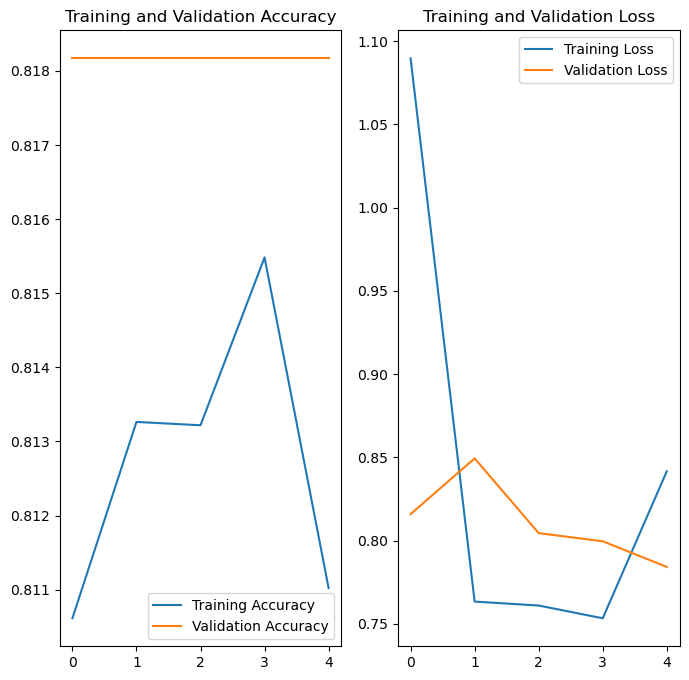

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
model.save('../model.keras')